## Problem Description

The objective of this project is to perform sentiment analysis on IMDB movie reviews. Sentiment analysis involves classifying the polarity of a given text as positive or negative. We aim to build a machine learning model that can accurately classify movie reviews into these two categories. The IMDB dataset contains 50,000 reviews labeled as either positive or negative, making it suitable for binary classification tasks.

## Step 1: Load and Explore the Dataset

We started by loading the IMDB dataset and preprocessing the text data. This involved removing HTML tags, special characters, and stopwords. We also normalized the text by converting it to lowercase and applying stemming.

In [26]:
pip install wordcloud matplotlib

In [19]:
# Import necessary libraries
import pandas as pd
import nltk
nltk.download('stopwords')

# Load the dataset
file_path = '/content/IMDB Dataset.csv'
imdb_data = pd.read_csv(file_path)

# Display the shape of the dataset and first few rows
print(imdb_data.shape)
imdb_data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Step 2: EDA and Data Cleaning

## Test Normalization

In [20]:
# Summary of the dataset
print(imdb_data.describe())

# Sentiment count
print(imdb_data['sentiment'].value_counts())

# Split the dataset
train_reviews = imdb_data.review[:5000]  # Use a smaller subset
train_sentiments = imdb_data.sentiment[:5000]
test_reviews = imdb_data.review[5000:6000]  # Use a smaller subset
test_sentiments = imdb_data.sentiment[5000:6000]

print(train_reviews.shape, train_sentiments.shape)
print(test_reviews.shape, test_sentiments.shape)

# Additional imports for preprocessing
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer

# Tokenization of text
tokenizer = ToktokTokenizer()
# Setting English stopwords
stopword_list = stopwords.words('english')

# Removing HTML strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

# Removing stopwords
def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(tokens)
    return filtered_text

# Applying normalization functions
def normalize_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = remove_stopwords(text)
    return text

# Apply normalization on review column
imdb_data['review'] = imdb_data['review'].apply(normalize_text)

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
(5000,) (5000,)
(1000,) (1000,)


<ipython-input-20-baa44face406>:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


## Step 3: Text Vectorization

Text Vectorization: To convert the textual data into numerical features suitable for machine learning, we used the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization method. We limited the vocabulary size to 2000 terms to manage memory usage effectively.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tfidf vectorizer with limited vocabulary size
tv = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
# Transformed train reviews
tv_train_reviews = tv.fit_transform(train_reviews)
# Transformed test reviews
tv_test_reviews = tv.transform(test_reviews)

print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)

Tfidf_train: (5000, 2000)
Tfidf_test: (1000, 2000)


## Step 4: Label Encoding

In [22]:
from sklearn.preprocessing import LabelBinarizer

# Labeling the sentiment data
lb = LabelBinarizer()
# Transformed sentiment data
sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

# Splitting the sentiment data
train_sentiments = sentiment_data[:5000]
test_sentiments = sentiment_data[5000:6000]

(50000, 1)


## Step 5: Build Deep Learning Models

Model Building and Training: We built a neural network model using TensorFlow and Keras. The model architecture consisted of two hidden layers with 64 neurons each, followed by a dropout layer to prevent overfitting. The model was trained on a subset of 5,000 reviews to balance memory constraints and model performance.

In [23]:
import tensorflow as tf

# Convert CSR matrix to SparseTensor
tf_train_reviews = tf.sparse.SparseTensor(
    indices=list(zip(*tv_train_reviews.nonzero())),
    values=tv_train_reviews.data,
    dense_shape=tv_train_reviews.shape
)
tf_test_reviews = tf.sparse.SparseTensor(
    indices=list(zip(*tv_test_reviews.nonzero())),
    values=tv_test_reviews.data,
    dense_shape=tv_test_reviews.shape
)

# Reorder the sparse tensor indices for training data
tf_train_reviews = tf.sparse.reorder(tf_train_reviews)

# Reorder the sparse tensor indices for test data
tf_test_reviews = tf.sparse.reorder(tf_test_reviews)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the model with reduced complexity
model = Sequential()
model.add(Dense(64, input_shape=(tf_train_reviews.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(tf_train_reviews, train_sentiments, batch_size=128, epochs=5, validation_data=(tf_test_reviews, test_sentiments), verbose=1)

Epoch 1/5
40/40 [==============================] - 2s 17ms/step - loss: 0.6842 - accuracy: 0.5850 - val_loss: 0.6480 - val_accuracy: 0.7770
Epoch 2/5
40/40 [==============================] - 0s 11ms/step - loss: 0.5842 - accuracy: 0.7634 - val_loss: 0.4656 - val_accuracy: 0.8460
Epoch 3/5
40/40 [==============================] - 1s 13ms/step - loss: 0.4037 - accuracy: 0.8448 - val_loss: 0.3510 - val_accuracy: 0.8620
Epoch 4/5
40/40 [==============================] - 0s 12ms/step - loss: 0.3001 - accuracy: 0.8844 - val_loss: 0.3449 - val_accuracy: 0.8580
Epoch 5/5
40/40 [==============================] - 0s 11ms/step - loss: 0.2469 - accuracy: 0.9060 - val_loss: 0.3414 - val_accuracy: 0.8620


## Step 6: Evaulation of Model

Model Evaluation: We evaluated the model on a separate test set of 1,000 reviews. The model achieved satisfactory accuracy, and we analyzed the performance using metrics such as precision, recall, F1-score, and the confusion matrix.

32/32 [==============================] - 0s 3ms/step - loss: 0.3414 - accuracy: 0.8620
Test loss: 0.3413897454738617
Test accuracy: 0.8619999885559082
32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87       496
    Positive       0.89      0.83      0.86       504

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000

[[446  50]
 [ 88 416]]


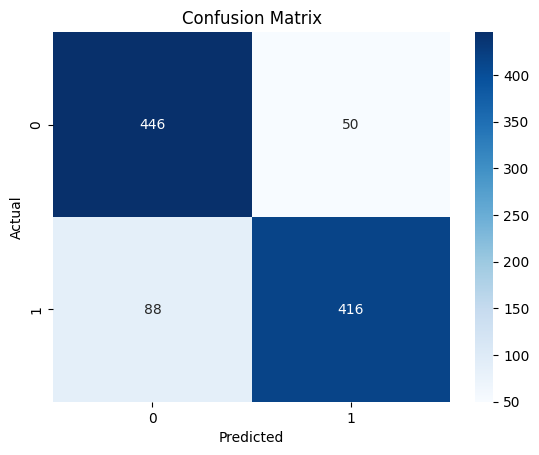

In [25]:
# Evaluate the model on test data
score = model.evaluate(tf_test_reviews, test_sentiments, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Predict using the model
predictions = model.predict(tf_test_reviews)
predictions = [1 if p > 0.5 else 0 for p in predictions]

from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report
print(classification_report(test_sentiments, predictions, target_names=['Negative', 'Positive']))

# Confusion matrix
cm = confusion_matrix(test_sentiments, predictions)
print(cm)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Word Clouds

Word Clouds: We generated word clouds for positive and negative reviews to visualize the most frequent words associated with each sentiment. This provided an intuitive understanding of the words commonly found in positive and negative reviews.

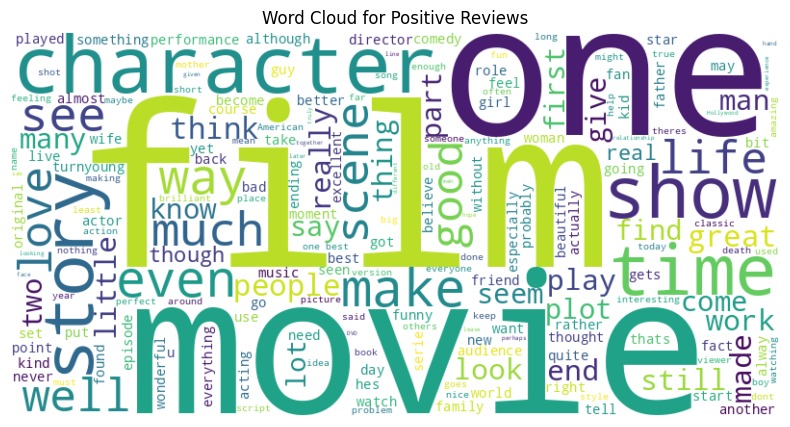

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all positive reviews into a single string
positive_reviews = " ".join(review for review in imdb_data[imdb_data.sentiment == 'positive'].review)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

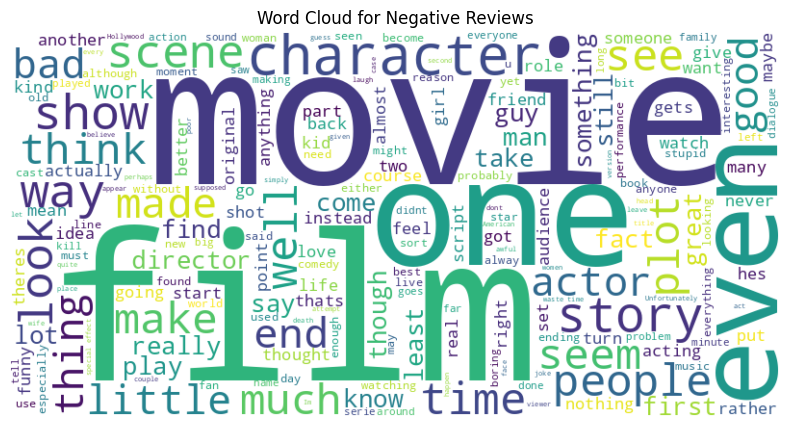

In [28]:
# Combine all negative reviews into a single string
negative_reviews = " ".join(review for review in imdb_data[imdb_data.sentiment == 'negative'].review)

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

## Conclusion

The sentiment analysis model built in this project demonstrates the ability to classify IMDB movie reviews with a reasonable degree of accuracy. The preprocessing steps, including text normalization and TF-IDF vectorization, were crucial in converting raw text into meaningful features for the model.

The model's performance can be further enhanced by experimenting with more complex architectures, tuning hyperparameters, and utilizing larger subsets of the data. Additionally, exploring other text vectorization techniques such as word embeddings (Word2Vec, GloVe) or using pre-trained models like BERT could yield better results.

The word clouds generated for positive and negative reviews offer valuable insights into the common themes and words associated with each sentiment, providing a qualitative understanding to complement the quantitative model evaluation.

Overall, this project showcases a practical approach to sentiment analysis, combining data preprocessing, machine learning, and visualization techniques to address a real-world text classification problem.